Running Sensitivity Analysis...


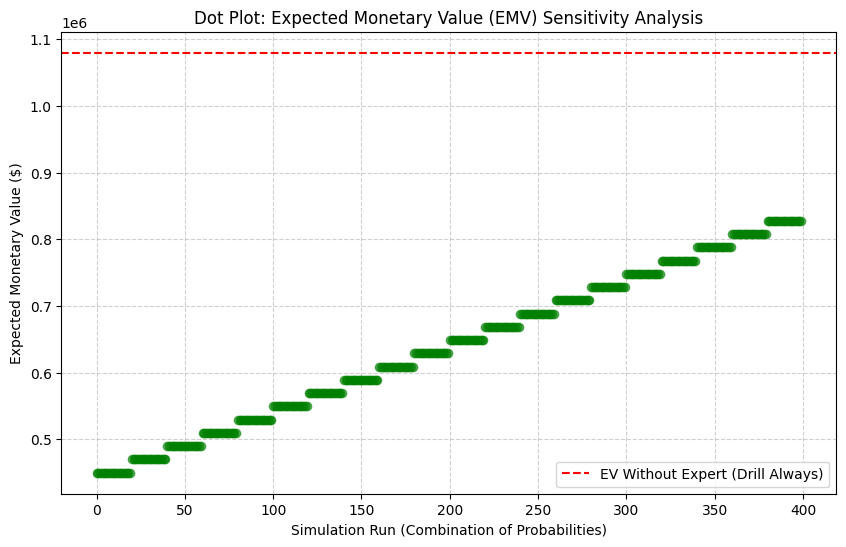


--- Sample Calculation (First 5 Runs) ---
   Sensitivity (Pred Oil|Oil)  Specificity (Pred No|No)  P(Oil|Pred Oil)  \
0                         0.5                  0.500000         0.700000   
1                         0.5                  0.515789         0.706695   
2                         0.5                  0.531579         0.713519   
3                         0.5                  0.547368         0.720477   
4                         0.5                  0.563158         0.727571   

        EMV  
0  450000.0  
1  450000.0  
2  450000.0  
3  450000.0  
4  450000.0  


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Parameters ---
p_oil_prior = 0.7          # Prior probability of Oil
p_no_oil_prior = 0.3       # Prior probability of No Oil
payoff_oil = 1_800_000     # Revenue if Oil is found
cost_rights = 180_000      # Cost to buy land rights

# Range for sensitivity analysis (0.5 to 0.8)
prob_range = np.linspace(0.5, 0.8, 20)

# --- 2. Bayes Theorem & Sensitivity Analysis ---
results = []

print("Running Sensitivity Analysis...")

# Loop 1: Sensitivity = P(Expert Says Oil | Oil Exists)
for sensitivity in prob_range:
    # Loop 2: Specificity = P(Expert Says No Oil | No Oil Exists)
    for specificity in prob_range:
        
        # Derived Conditional Probabilities
        # P(Expert Says Oil | No Oil) = 1 - Specificity
        p_pred_oil_given_no_oil = 1 - specificity
        
        # Total Probability of Expert Predicting Oil
        # P(Pred Oil) = P(Pred Oil|Oil)*P(Oil) + P(Pred Oil|No Oil)*P(No Oil)
        p_pred_oil = (sensitivity * p_oil_prior) + (p_pred_oil_given_no_oil * p_no_oil_prior)
        
        # BAYES THEOREM: Posterior Probability of Oil given Expert Predicted Oil
        # P(Oil | Pred Oil) = (P(Pred Oil|Oil) * P(Oil)) / P(Pred Oil)
        if p_pred_oil > 0:
            p_oil_given_pred_oil = (sensitivity * p_oil_prior) / p_pred_oil
        else:
            p_oil_given_pred_oil = 0

        # --- Calculate Expected Monetary Value (EMV) ---
        # Strategy: Buy Rights. 
        # If Expert says "Oil" -> We Drill. 
        # If Expert says "No Oil" -> We Don't Drill (Cost is just the rights).
        
        # EV Branch 1: Expert Says Oil (We Drill)
        # Outcome A: Oil Exists (Payoff - Cost)
        # Outcome B: No Oil (0 - Cost)
        # Expected Value given Pred Oil = [P(Oil|Pred Oil) * Payoff] - Cost_Rights
        ev_given_pred_oil = (p_oil_given_pred_oil * payoff_oil) - cost_rights
        
        # EV Branch 2: Expert Says No Oil (We Don't Drill)
        # We assume if Expert says no, we walk away. We only lost the land rights cost.
        ev_given_pred_no_oil = -cost_rights
        
        # Total EMV = P(Pred Oil) * EV(Branch 1) + P(Pred No Oil) * EV(Branch 2)
        p_pred_no_oil = 1 - p_pred_oil
        total_emv = (p_pred_oil * ev_given_pred_oil) + (p_pred_no_oil * ev_given_pred_no_oil)
        
        results.append({
            'Sensitivity (Pred Oil|Oil)': sensitivity,
            'Specificity (Pred No|No)': specificity,
            'P(Oil|Pred Oil)': p_oil_given_pred_oil,
            'EMV': total_emv
        })

# Convert to DataFrame for easier inspection
df_results = pd.DataFrame(results)

# --- 3. Dot Plot Visualization ---
plt.figure(figsize=(10, 6))

# Plotting the Dot Plot of Expected Monetary Values
plt.plot(df_results.index, df_results['EMV'], 'o', alpha=0.6, color='green')

plt.title('Dot Plot: Expected Monetary Value (EMV) Sensitivity Analysis')
plt.xlabel('Simulation Run (Combination of Probabilities)')
plt.ylabel('Expected Monetary Value ($)')
plt.grid(True, linestyle='--', alpha=0.6)

# Add reference line for "Do Nothing" (EV = 0) or "Buy without Expert"
# EV Without Expert = (0.7 * 1.8M) - 180k = 1,080,000 (assuming we drill)
plt.axhline(y=1080000, color='r', linestyle='--', label='EV Without Expert (Drill Always)')
plt.legend()

plt.show()

# Display a sample of the Bayes calculations
print("\n--- Sample Calculation (First 5 Runs) ---")
print(df_results[['Sensitivity (Pred Oil|Oil)', 'Specificity (Pred No|No)', 'P(Oil|Pred Oil)', 'EMV']].head())

--- Linear Regression Results ---
MSE (Test): 10.7109
R-squared (Test): 0.7902

--- Ridge Regression Results ---
Best Alpha found: 2.0236
Ridge Score (Training R^2): 0.8258
MSE (Test): 10.8203
Ridge Score (Testing R^2): 0.7880


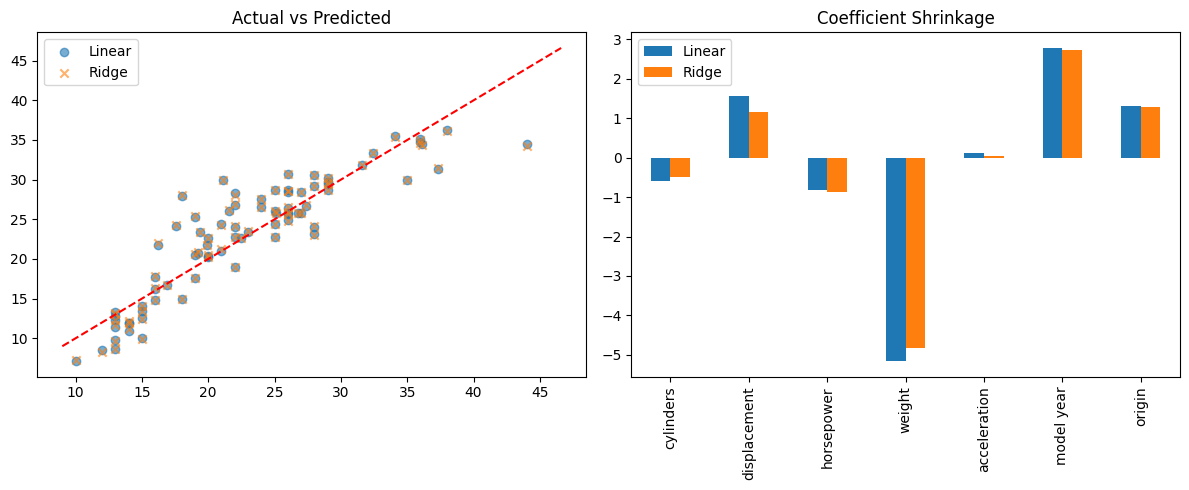

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# --- 1. Load & Clean Data ---
# Using read_excel for .xlsx files
df_mpg = pd.read_excel('auto-mpg.xlsx')

# Clean 'horsepower' (convert '?' to NaN and drop)
df_mpg['horsepower'] = pd.to_numeric(df_mpg['horsepower'], errors='coerce')
df_mpg.dropna(inplace=True)

# Select features and target
X = df_mpg.drop(['mpg', 'car name'], axis=1, errors='ignore')
y = df_mpg['mpg']

# --- 2. Separate into Training and Testing Data (2 points) ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data (Crucial for Ridge)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 3. Construct Linear Regression Model (4 points) ---
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

# --- 4. Linear Regression Metrics (Test Data) (4 points) ---
y_pred_lr = lr.predict(X_test_scaled)
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print("--- Linear Regression Results ---")
print(f"MSE (Test): {mse_lr:.4f}")
print(f"R-squared (Test): {r2_lr:.4f}")

# --- 5. Create Ridge Regression Model & Find Alpha (2 + 3 points) ---
# We use RidgeCV to automatically find the best alpha
alphas = np.logspace(-3, 3, 50)
ridge_cv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error')
ridge_cv.fit(X_train_scaled, y_train)

best_alpha = ridge_cv.alpha_
print(f"\n--- Ridge Regression Results ---")
print(f"Best Alpha found: {best_alpha:.4f}")

# Create the final model with the best alpha
ridge = Ridge(alpha=best_alpha)
ridge.fit(X_train_scaled, y_train)

# --- 6. Ridge Score on TRAINING Data (4 points) ---
# (This was missing in the previous visualization script)
ridge_score_train = ridge.score(X_train_scaled, y_train)
print(f"Ridge Score (Training R^2): {ridge_score_train:.4f}")

# --- 7. MSE and Ridge Score on TESTING Data (4 points) ---
y_pred_ridge = ridge.predict(X_test_scaled)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
ridge_score_test = ridge.score(X_test_scaled, y_test)

print(f"MSE (Test): {mse_ridge:.4f}")
print(f"Ridge Score (Testing R^2): {ridge_score_test:.4f}")

# --- Visualization (Optional but recommended) ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_lr, alpha=0.6, label='Linear')
plt.scatter(y_test, y_pred_ridge, alpha=0.6, marker='x', label='Ridge')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.title("Actual vs Predicted")
plt.legend()

plt.subplot(1, 2, 2)
coef_df = pd.DataFrame({'Linear': lr.coef_, 'Ridge': ridge.coef_}, index=X.columns)
coef_df.plot(kind='bar', ax=plt.gca())
plt.title("Coefficient Shrinkage")
plt.tight_layout()
plt.show()

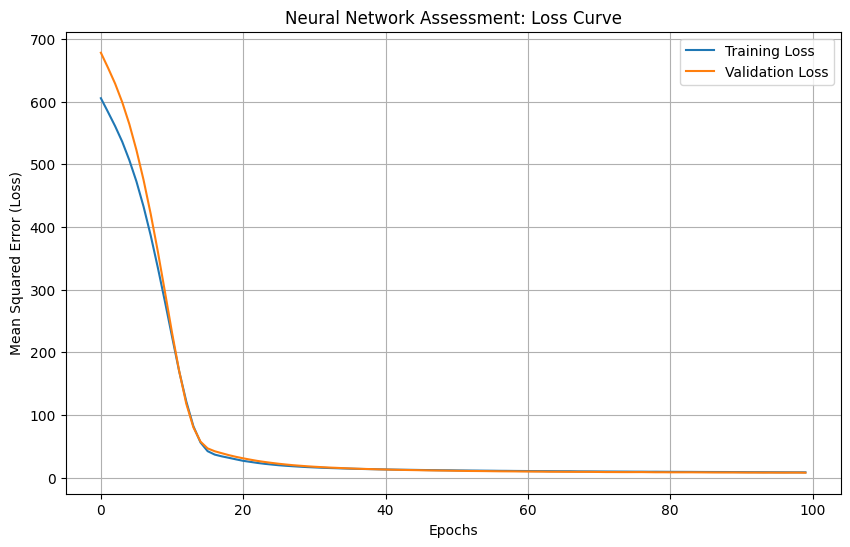

3/3 [==============================] - 0s 817us/step
--- PERFORMANCE COMPARISON ---
Linear Regression MSE: 10.7109
Neural Network MSE:    8.1556
------------------------------
Conclusion: The Neural Network OUTPERFORMED the Linear Regression model.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# --- 1. PREP DATA (Required for the script to run standalone) ---
df_mpg = pd.read_excel('auto-mpg.xlsx')
df_mpg['horsepower'] = pd.to_numeric(df_mpg['horsepower'], errors='coerce')
df_mpg.dropna(inplace=True)

X = df_mpg.drop(['mpg', 'car name'], axis=1, errors='ignore')
y = df_mpg['mpg']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# (Re-run Regression to have a baseline for comparison)
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
mse_lr = mean_squared_error(y_test, y_pred_lr)

# ==============================================================================
# PART 3: NEURAL NETWORK
# ==============================================================================

# --- 1. Construct Neural Network (10 points) ---
model = Sequential()

# Input Layer + Hidden Layer 1
model.add(Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)))

# Hidden Layer 2
model.add(Dense(32, activation='relu'))

# Output Layer (1 node for regression prediction)
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# --- 2. Train & Assess (8 points) ---
# We use validation_split=0.2 to monitor overfitting during training
history = model.fit(X_train_scaled, y_train, 
                    validation_split=0.2, 
                    epochs=100, 
                    verbose=0)

# VISUAL ASSESSMENT: Plotting Training vs Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Neural Network Assessment: Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (Loss)')
plt.legend()
plt.grid(True)
plt.show()

# --- 3. Performance & Comparison (5 points) ---
# Predictions
y_pred_nn = model.predict(X_test_scaled).flatten()

# Metrics
mse_nn = mean_squared_error(y_test, y_pred_nn)
r2_nn = r2_score(y_test, y_pred_nn)

print("--- PERFORMANCE COMPARISON ---")
print(f"Linear Regression MSE: {mse_lr:.4f}")
print(f"Neural Network MSE:    {mse_nn:.4f}")
print("-" * 30)
if mse_nn < mse_lr:
    print("Conclusion: The Neural Network OUTPERFORMED the Linear Regression model.")
else:
    print("Conclusion: The Neural Network UNDERPERFORMED the Linear Regression model.")

2025-12-11 20:08:04.529449: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


8/8 [==============================] - 0s 358us/step


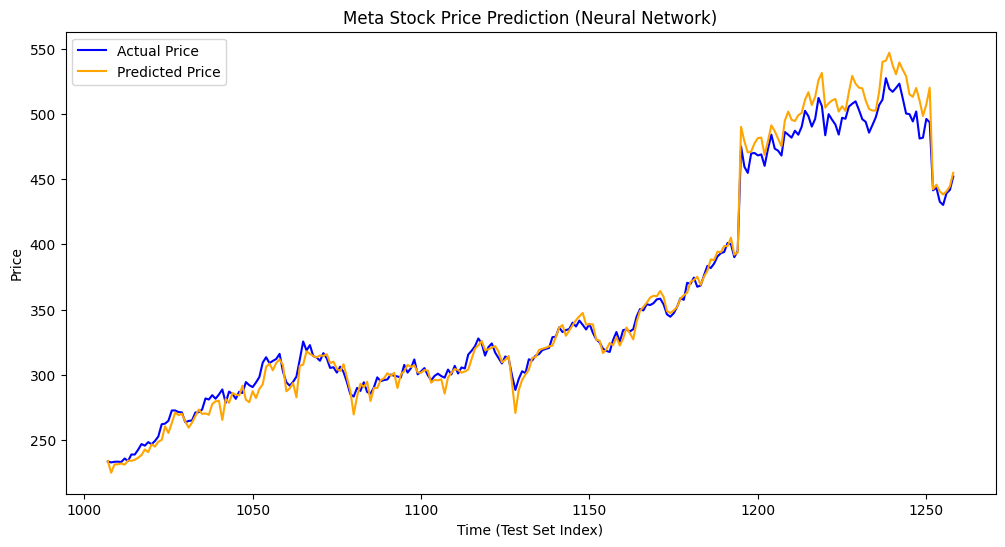

--- Meta Model Evaluation ---
Meta Test MSE: 86.0833


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# 1. Load Data
# CHANGED: Use read_excel for .xlsx files
df_meta = pd.read_excel('META.xlsx')

# Feature Selection: Use Open, High, Low, Volume to predict Close
features = ['Open', 'High', 'Low', 'Volume']
target = 'Close'

# Prepare X and y
X_meta = df_meta[features].values
y_meta = df_meta[target].values

# Scaling
scaler_X = StandardScaler()
X_meta_scaled = scaler_X.fit_transform(X_meta)

# Manual Split to preserve order (Time Series Split)
split_idx = int(len(df_meta) * 0.8)
X_train_m, X_test_m = X_meta_scaled[:split_idx], X_meta_scaled[split_idx:]
y_train_m, y_test_m = y_meta[:split_idx], y_meta[split_idx:]

# 2. Construct Neural Network
model_meta = Sequential()

# Input layer + 1st Hidden Layer (64 neurons, ReLU)
model_meta.add(Dense(64, activation='relu', input_shape=(X_train_m.shape[1],)))
# Dropout to prevent overfitting
model_meta.add(Dropout(0.2))
# 2nd Hidden Layer (32 neurons, ReLU)
model_meta.add(Dense(32, activation='relu'))
# Output Layer (1 neuron for regression)
model_meta.add(Dense(1))

model_meta.compile(optimizer='adam', loss='mean_squared_error')

# Train
history_meta = model_meta.fit(X_train_m, y_train_m, epochs=50, batch_size=32, validation_data=(X_test_m, y_test_m), verbose=0)

# 3. Assess the Model
y_pred_meta = model_meta.predict(X_test_m)

plt.figure(figsize=(12, 6))
# Create an index range for the test set for plotting
test_range = range(len(y_train_m), len(y_train_m) + len(y_test_m))
plt.plot(test_range, y_test_m, label='Actual Price', color='blue')
plt.plot(test_range, y_pred_meta, label='Predicted Price', color='orange')
plt.title('Meta Stock Price Prediction (Neural Network)')
plt.xlabel('Time (Test Set Index)')
plt.ylabel('Price')
plt.legend()
plt.show()

print("--- Meta Model Evaluation ---")
print(f"Meta Test MSE: {mean_squared_error(y_test_m, y_pred_meta):.4f}")